In [ ]:
# ---- Step 0: Setup and Imports ----

import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Optional: Install pygam if missing
try:
    from pygam import LinearGAM, s, f
except ImportError:
    !{sys.executable} -m pip install pygam
    from pygam import LinearGAM, s, f

# Global config
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [2]:
# ---- Step 1: Load Raw Input Files and Preview ----

# Define paths
BASE_PATH = (
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/"
    "nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed"
)

CT_PATH = os.path.join(BASE_PATH, "ct_master.csv")
MODALITY_COUNTS_PATH = os.path.join(BASE_PATH, "modality_procedure_counts_by_age_band_2024.csv")
POPULATION_PATH = os.path.join(BASE_PATH, "south_west_population_2024.csv")

# Load CSV files
ct_master_df = pd.read_csv(CT_PATH)
modality_counts_df = pd.read_csv(MODALITY_COUNTS_PATH)
population_df = pd.read_csv(POPULATION_PATH)

# Preview key dataframes
for name, df in {
    "CT Master": ct_master_df,
    "Modality Counts (2024)": modality_counts_df,
    "Population (2024)": population_df,
}.items():
    print(f"\n{name} — shape: {df.shape}")
    print(df.head())



CT Master — shape: (647476, 30)
  icb_code                icb_name  lsoa_code  \
0      11X  NHS SOMERSET ICB - 11X  E01029112   
1      11X  NHS SOMERSET ICB - 11X  E01029135   
2      11X  NHS SOMERSET ICB - 11X  E01029237   
3      11X  NHS SOMERSET ICB - 11X  E01029255   
4      11X  NHS SOMERSET ICB - 11X  E01029205   

                        nhs_region site_code                       site_name  \
0  Head structure (body structure)     RH5A8  MUSGROVE PARK HOSPITAL (RH5A8)   
1  Head structure (body structure)     RH5A8  MUSGROVE PARK HOSPITAL (RH5A8)   
2  Head structure (body structure)     RH504  GREENFIELDS DAY CENTRE (RH504)   
3                              NaN     RH504  GREENFIELDS DAY CENTRE (RH504)   
4  Head structure (body structure)     RH504  GREENFIELDS DAY CENTRE (RH504)   

  provider_code                  provider_name  activity_month financial_year  \
0           RH5  SOMERSET NHS FOUNDATION TRUST          202403        2023/24   
1           RH5  SOMERSET NHS

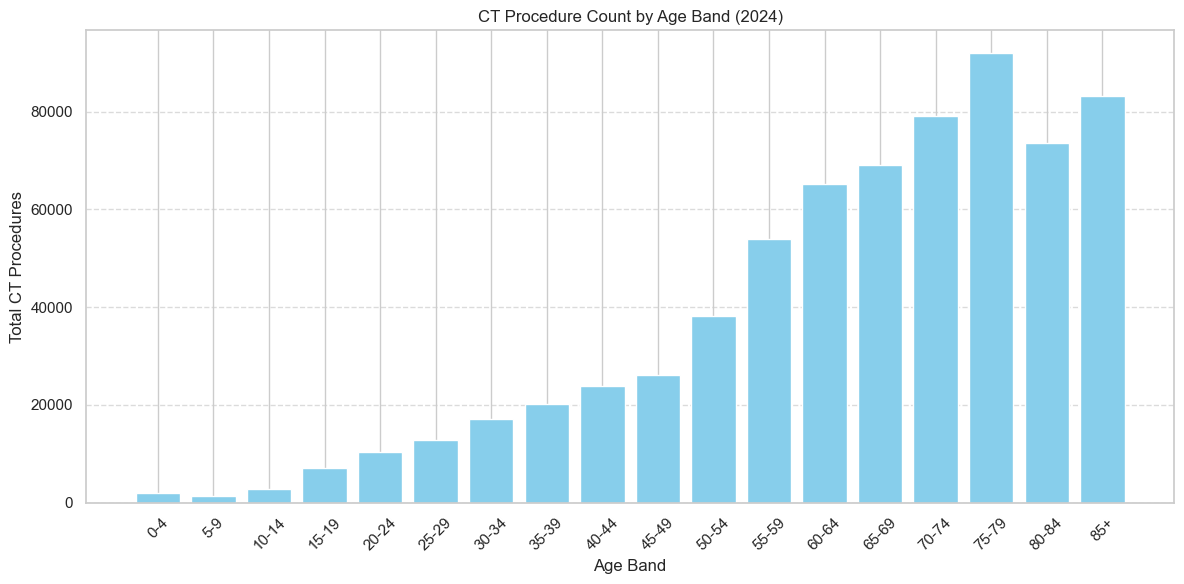

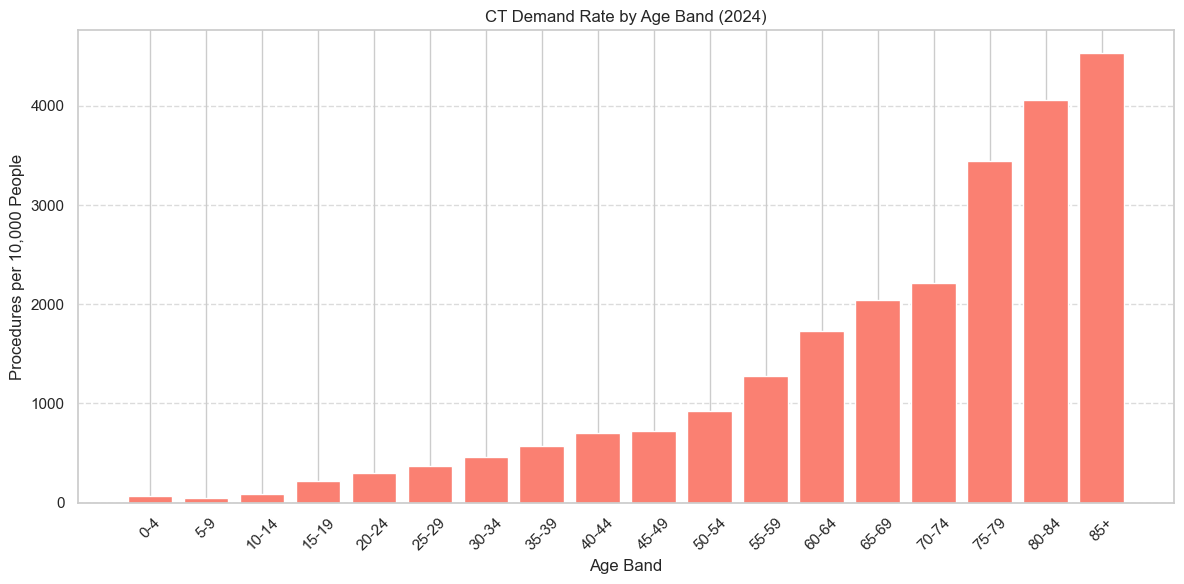

Sum of PDF (should equal 1.0): 1.000000


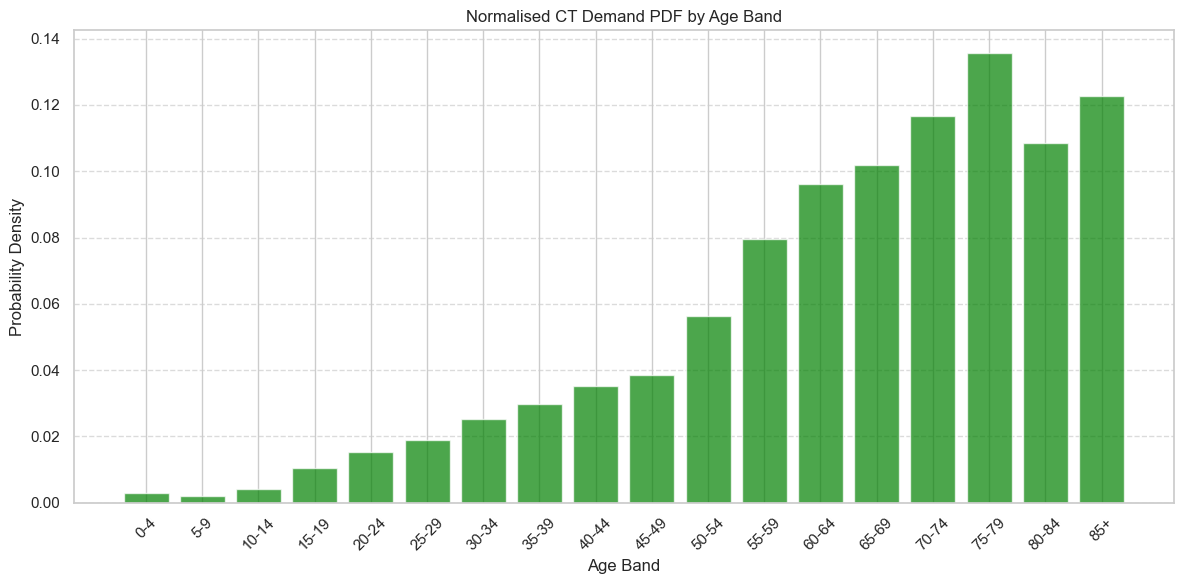

In [3]:
# ---- Step 2: Naïve CT Demand Model by Age Band (Aggregate) ----

# Define population by age band (2024 projection)
age_band_population = pd.DataFrame({
    "age_band": [
        "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
        "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74",
        "75-79", "80-84", "85+"
    ],
    "population_2024": [
        283792, 322018, 331416, 324765, 342425, 342688, 367510, 355513,
        341210, 362553, 413048, 423510, 376552, 337298, 357074,
        266939, 181501, 183436
    ]
})

# Merge CT totals with age-band population
ct_df = modality_counts_df[["age_band", "CT_Total"]].copy()
ct_df = ct_df.merge(age_band_population, on="age_band", how="left")

# Calculate demand rates
ct_df["ct_demand_per_10k"] = (ct_df["CT_Total"] / ct_df["population_2024"]) * 10000
ct_df["ct_demand_per_1k"] = (ct_df["CT_Total"] / ct_df["population_2024"]) * 1000

# Round for readability
ct_df[["ct_demand_per_10k", "ct_demand_per_1k"]] = ct_df[
    ["ct_demand_per_10k", "ct_demand_per_1k"]
].round(2)

# ---- Visualisation: Total CT Volumes by Age Band ----

plt.figure(figsize=(12, 6))
plt.bar(ct_df["age_band"], ct_df["CT_Total"], color="skyblue")
plt.xlabel("Age Band")
plt.ylabel("Total CT Procedures")
plt.title("CT Procedure Count by Age Band (2024)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# ---- Visualisation: Demand Rate per 10,000 People ----

plt.figure(figsize=(12, 6))
plt.bar(ct_df["age_band"], ct_df["ct_demand_per_10k"], color="salmon")
plt.xlabel("Age Band")
plt.ylabel("Procedures per 10,000 People")
plt.title("CT Demand Rate by Age Band (2024)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# ---- Generate Normalised Probability Density Function (PDF) ----

ct_df["total_demand"] = (ct_df["ct_demand_per_1k"] * ct_df["population_2024"]) / 1000
total_demand_sum = ct_df["total_demand"].sum()
ct_df["demand_pdf"] = ct_df["total_demand"] / total_demand_sum

print(f"Sum of PDF (should equal 1.0): {ct_df['demand_pdf'].sum():.6f}")

# ---- Visualisation: CT Demand PDF by Age Band ----

plt.figure(figsize=(12, 6))
plt.bar(ct_df["age_band"], ct_df["demand_pdf"], alpha=0.7, color="green")
plt.xlabel("Age Band")
plt.ylabel("Probability Density")
plt.title("Normalised CT Demand PDF by Age Band")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


Age column dtype: float64
Missing age values: 13
count    647463.000000
mean         65.366083
std          18.376642
min           0.000000
25%          55.000000
50%          69.000000
75%          79.000000
max         109.000000
Name: age, dtype: float64


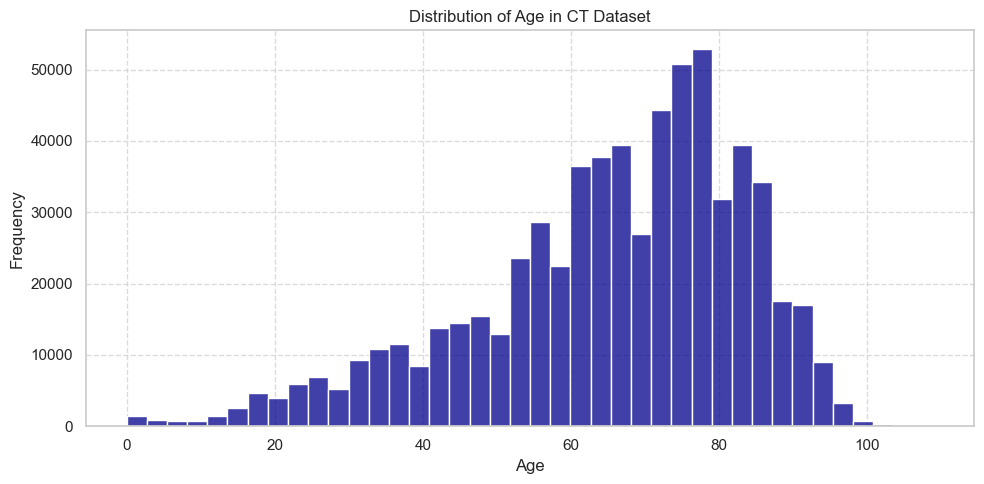

In [4]:
# ---- Step 3A: CT Demand Model by Continuous Age (0–100) ----

# Filter only CT records
ct_df_cont = ct_master_df[ct_master_df["is_ct"] == 1].copy()

# ---- Sanity Check: Age Field ----

# Check type, nulls, and descriptive stats
print("Age column dtype:", ct_df_cont["age"].dtype)
print("Missing age values:", ct_df_cont["age"].isna().sum())
print(ct_df_cont["age"].describe())

# Check age value distribution
plt.figure(figsize=(10, 5))
sns.histplot(ct_df_cont["age"].dropna(), bins=40, kde=False, color="darkblue")
plt.title("Distribution of Age in CT Dataset")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


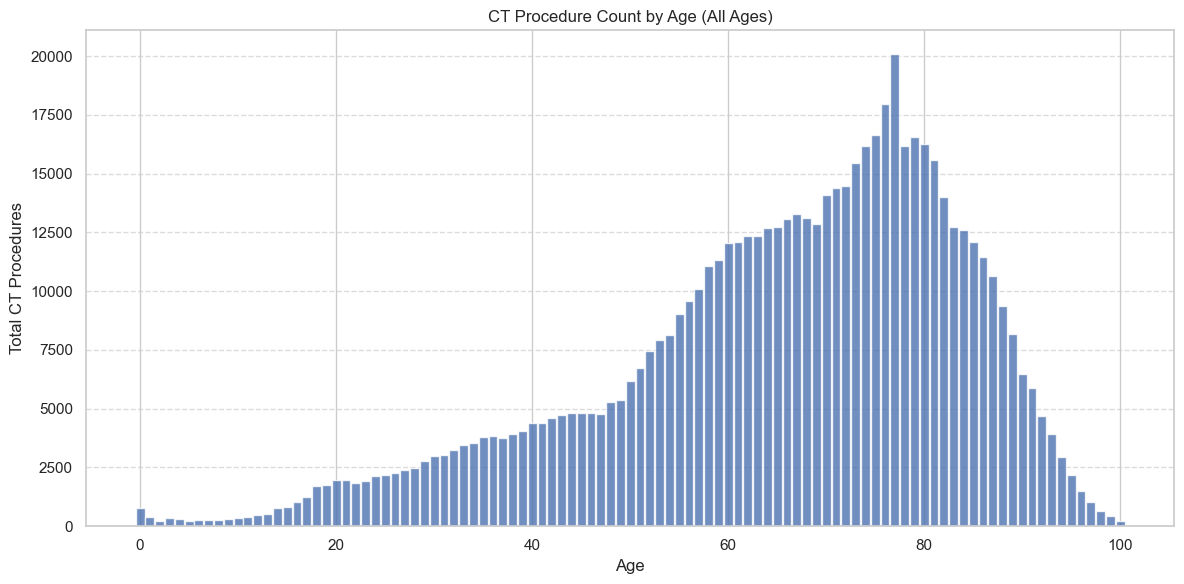

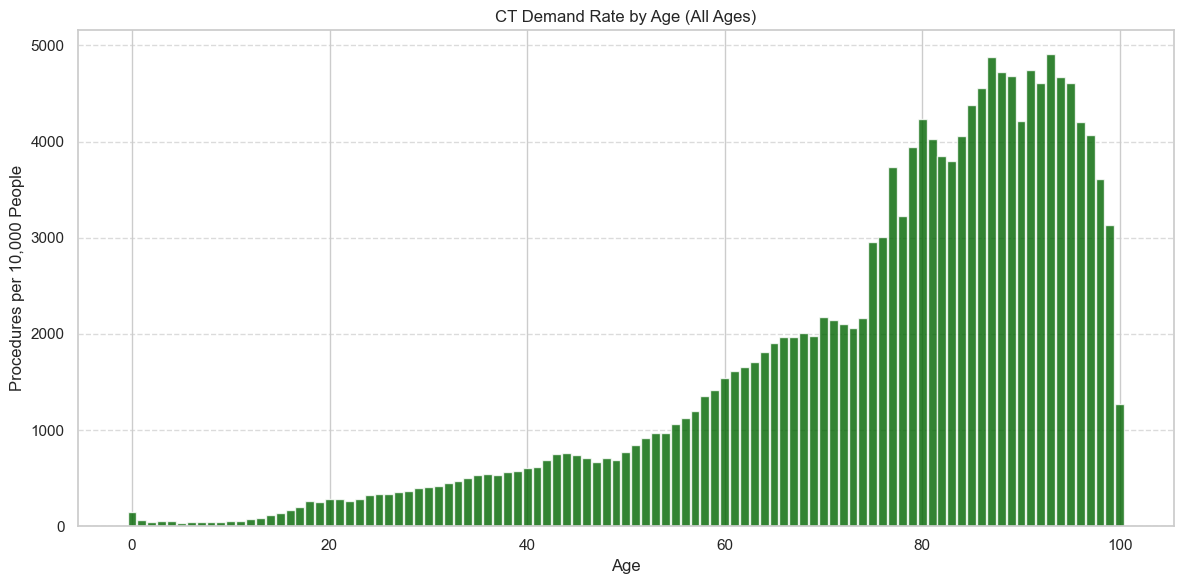

In [6]:
# ---- Step 3A (continued): Calculate CT Demand per Age ----

# Drop rows with missing age or population
ct_df_cont = ct_df_cont.dropna(subset=["age"])
population_df = pd.read_csv(POPULATION_PATH)
population_df.rename(columns={"population": "population_2024"}, inplace=True)

# Ensure age is integer for grouping
ct_df_cont["age"] = ct_df_cont["age"].astype(int)

# Step 1: Count total CT procedures by age
ct_by_age = (
    ct_df_cont.groupby("age")
    .size()
    .reset_index(name="CT_Total")
)

# Step 2: Merge with population
merged_df = ct_by_age.merge(population_df, on="age", how="left")
merged_df.dropna(subset=["population_2024"], inplace=True)

# Step 3: Calculate CT demand rates
merged_df["ct_demand_per_1k"] = (merged_df["CT_Total"] / merged_df["population_2024"]) * 1000
merged_df["ct_demand_per_10k"] = (merged_df["CT_Total"] / merged_df["population_2024"]) * 10000

# Step 4: Round for readability
merged_df[["ct_demand_per_1k", "ct_demand_per_10k"]] = merged_df[
    ["ct_demand_per_1k", "ct_demand_per_10k"]
].round(2)

# Step 5: Sort by age
merged_df.sort_values("age", inplace=True)

# ---- Visualise: CT Procedure Volume by Age ----

plt.figure(figsize=(12, 6))
plt.bar(merged_df["age"], merged_df["CT_Total"], width=0.9, alpha=0.8)
plt.xlabel("Age")
plt.ylabel("Total CT Procedures")
plt.title("CT Procedure Count by Age (All Ages)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# ---- Visualise: Demand Rate per 10,000 by Age ----

plt.figure(figsize=(12, 6))
plt.bar(merged_df["age"], merged_df["ct_demand_per_10k"], width=0.9, alpha=0.8, color="darkgreen")
plt.xlabel("Age")
plt.ylabel("Procedures per 10,000 People")
plt.title("CT Demand Rate by Age (All Ages)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


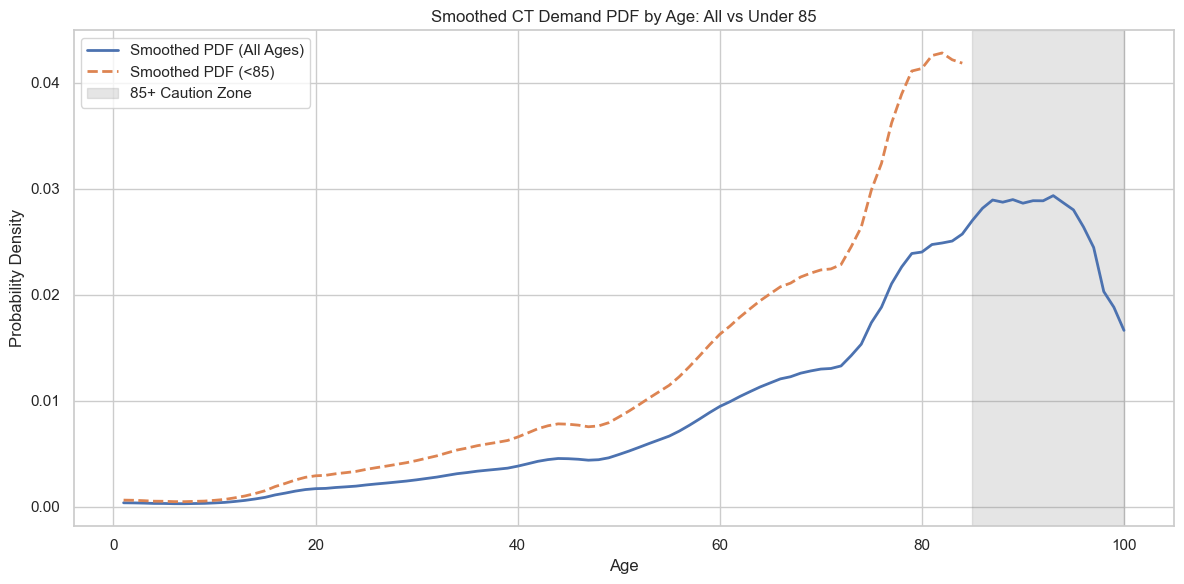

In [8]:
# ---- Step 3A.1: PDF Generation and Smoothing ----

# Full age range 1–100+
full_age_range = pd.DataFrame({"age": np.arange(1, 101)})
merged_full = full_age_range.merge(
    merged_df[["age", "ct_demand_per_1k"]],
    on="age",
    how="left"
)
merged_full["ct_demand_per_1k"].fillna(0, inplace=True)

# PDF and smoothing (all ages)
demand_all = merged_full["ct_demand_per_1k"].values
pdf_all = demand_all / demand_all.sum()
merged_full["pdf_all"] = pdf_all
merged_full["pdf_all_smoothed"] = merged_full["pdf_all"].rolling(
    window=5, center=True, min_periods=1
).mean()

# PDF and smoothing (<85 subset)
subset_df = merged_full[merged_full["age"] < 85].copy()
demand_sub = subset_df["ct_demand_per_1k"].values
pdf_sub = demand_sub / demand_sub.sum()
subset_df["pdf_sub"] = pdf_sub
subset_df["pdf_sub_smoothed"] = subset_df["pdf_sub"].rolling(
    window=5, center=True, min_periods=1
).mean()

# ---- Visualise: All Ages vs <85 Smoothed PDFs ----

plt.figure(figsize=(12, 6))
plt.plot(
    merged_full["age"], merged_full["pdf_all_smoothed"],
    label="Smoothed PDF (All Ages)", linewidth=2
)
plt.plot(
    subset_df["age"], subset_df["pdf_sub_smoothed"],
    label="Smoothed PDF (<85)", linewidth=2, linestyle="--"
)
plt.xlabel("Age")
plt.ylabel("Probability Density")
plt.title("Smoothed CT Demand PDF by Age: All vs Under 85")
plt.axvspan(85, 100, color='grey', alpha=0.2, label="85+ Caution Zone")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# ---- Step 3A.2: Apply Moving Average Smoothing to PDFs ----

# Define rolling window size
window_size = 5

# Smooth full-age PDF
merged_full["pdf_all_smoothed"] = merged_full["pdf_all"].rolling(
    window=window_size, center=True, min_periods=1
).mean()

# Smooth <85 PDF
subset_df["pdf_sub_smoothed"] = subset_df["pdf_sub"].rolling(
    window=window_size, center=True, min_periods=1
).mean()


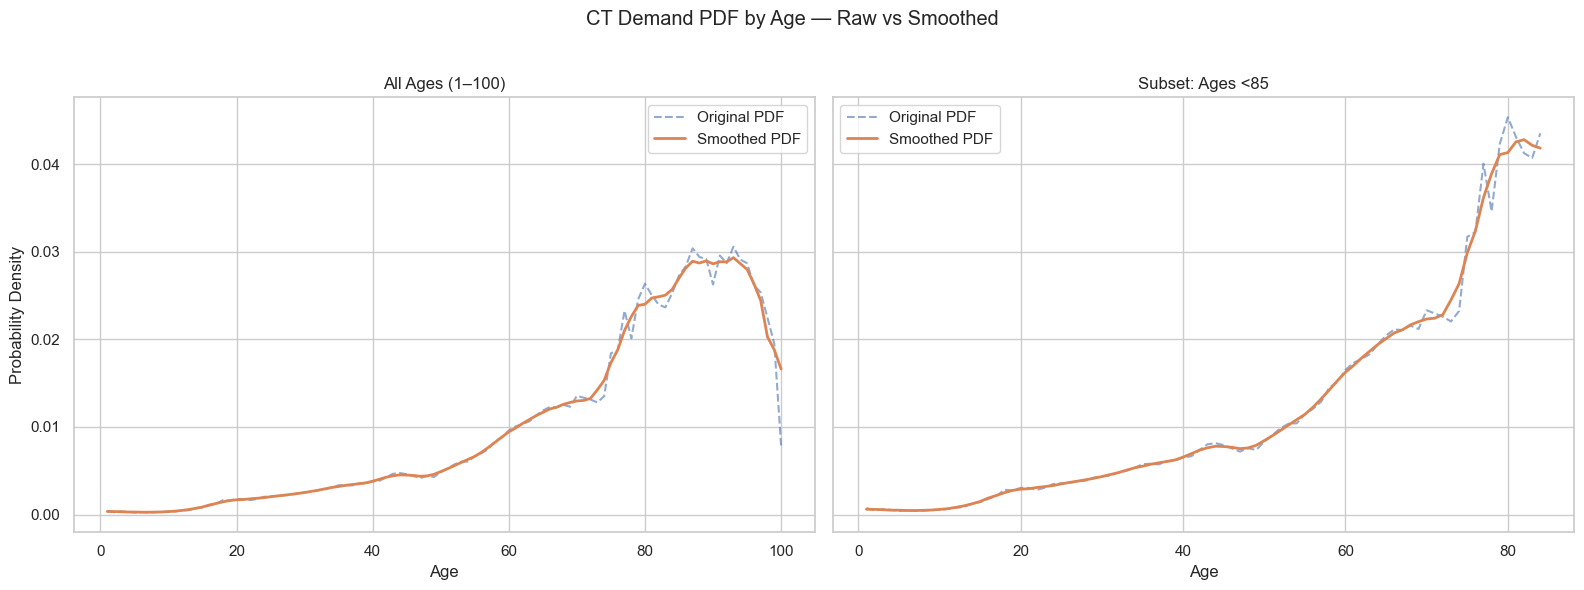

In [10]:
# ---- Side-by-Side Plot: Raw vs Smoothed PDFs (All Ages) ----

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Panel A: All Ages
ax[0].plot(
    merged_full["age"], merged_full["pdf_all"],
    label="Original PDF", alpha=0.6, linestyle="--"
)
ax[0].plot(
    merged_full["age"], merged_full["pdf_all_smoothed"],
    label="Smoothed PDF", linewidth=2
)
ax[0].set_title("All Ages (1–100)")
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Probability Density")
ax[0].legend()
ax[0].grid(True)

# Panel B: Subset <85
ax[1].plot(
    subset_df["age"], subset_df["pdf_sub"],
    label="Original PDF", alpha=0.6, linestyle="--"
)
ax[1].plot(
    subset_df["age"], subset_df["pdf_sub_smoothed"],
    label="Smoothed PDF", linewidth=2
)
ax[1].set_title("Subset: Ages <85")
ax[1].set_xlabel("Age")
ax[1].legend()
ax[1].grid(True)

plt.suptitle("CT Demand PDF by Age — Raw vs Smoothed")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [11]:
# ---- Optional: Output CT Demand PDF Tables ----

# Preview smoothed CT demand PDF (full age)
print("Smoothed CT PDF – All Ages (head):")
print(merged_full[["age", "ct_demand_per_1k", "pdf_all_smoothed"]].tail())

# Preview smoothed CT demand PDF (<85)
print("\nSmoothed CT PDF – Age <85 (tail):")
print(subset_df[["age", "ct_demand_per_1k", "pdf_sub_smoothed"]].tail())


Smoothed CT PDF – All Ages (head):
    age  ct_demand_per_1k  pdf_all_smoothed
95   96            420.63          0.026370
96   97            407.15          0.024445
97   98            360.74          0.020287
98   99            312.99          0.018808
99  100            126.84          0.016623

Smoothed CT PDF – Age <85 (tail):
    age  ct_demand_per_1k  pdf_sub_smoothed
79   80            423.19          0.041333
80   81            402.22          0.042554
81   82            384.82          0.042801
82   83            379.83          0.042159
83   84            406.03          0.041837


In [12]:
# ---- Step 4.1: Fit GLM and Random Forest Models ----

# Prepare modelling dataframe
model_df = merged_full.copy()
model_df = model_df.dropna(subset=["ct_demand_per_1k"])
model_df = model_df[model_df["age"] <= 100]

# Fit Poisson GLM using statsmodels
glm_model = smf.glm(
    formula="ct_demand_per_1k ~ age",
    data=model_df,
    family=sm.families.Poisson()
).fit()

# Store GLM predictions
model_df["predicted_glm"] = glm_model.predict(model_df)

# Fit Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(model_df[["age"]], model_df["ct_demand_per_1k"])
model_df["predicted_rf"] = rf_model.predict(model_df[["age"]])


In [13]:
# ---- Step 4.2: GLM Confidence Intervals ----

pred_summary = glm_model.get_prediction(model_df).summary_frame(alpha=0.05)
model_df["glm_ci_lower"] = pred_summary["mean_ci_lower"]
model_df["glm_ci_upper"] = pred_summary["mean_ci_upper"]


In [14]:
# ---- Step 4.3: Ensemble and Smoothing (Rolling Avg) ----

# Weighted average
model_df["predicted_ensemble"] = (
    0.6 * model_df["predicted_glm"] + 0.4 * model_df["predicted_rf"]
)

# Apply moving average smoothing (window = 5)
for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
    model_df[f"{col}_smoothed"] = model_df[col].rolling(
        window=5, center=True, min_periods=1
    ).mean()

# Smooth CIs for visual consistency
model_df["glm_ci_lower_smoothed"] = model_df["glm_ci_lower"].rolling(
    window=5, center=True, min_periods=1
).mean()
model_df["glm_ci_upper_smoothed"] = model_df["glm_ci_upper"].rolling(
    window=5, center=True, min_periods=1
).mean()


In [15]:
# ---- Step 4.4: Evaluate All Models ----

def evaluate(true, pred, name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"{name:<30} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

evaluate(model_df["ct_demand_per_1k"], model_df["predicted_glm_smoothed"], "Poisson GLM (Smoothed)")
evaluate(model_df["ct_demand_per_1k"], model_df["predicted_rf_smoothed"], "Random Forest (Smoothed)")
evaluate(model_df["ct_demand_per_1k"], model_df["predicted_ensemble_smoothed"], "Ensemble (Smoothed)")


Poisson GLM (Smoothed)         | MAE: 33.25 | RMSE: 69.49 | R²: 0.808
Random Forest (Smoothed)       | MAE: 7.45 | RMSE: 19.90 | R²: 0.984
Ensemble (Smoothed)            | MAE: 21.55 | RMSE: 47.31 | R²: 0.911


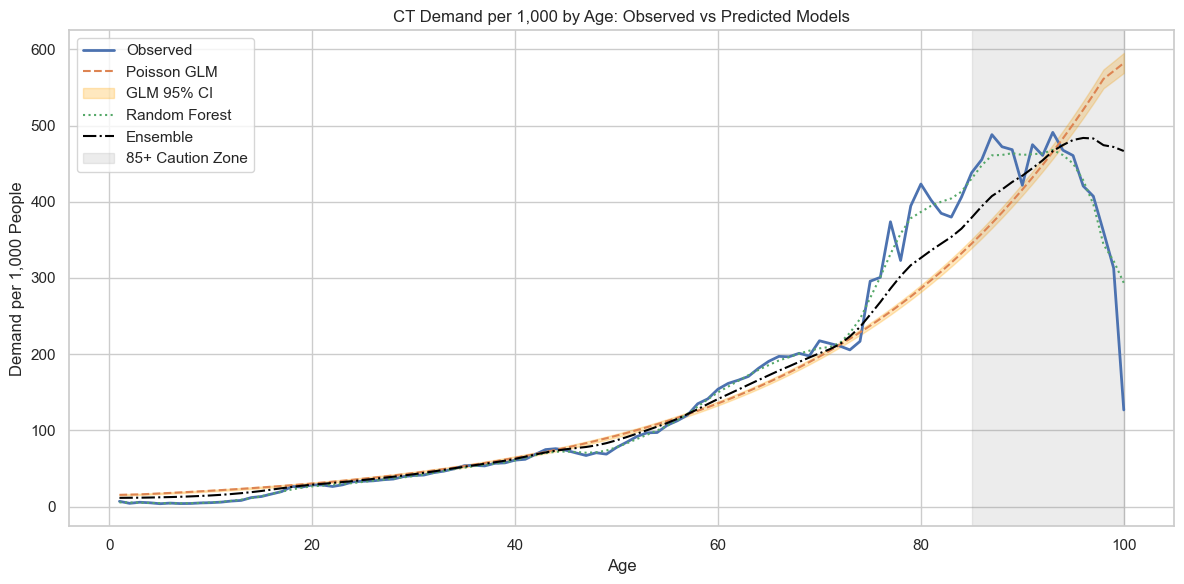

In [16]:
# ---- Step 4.5: Observed vs Predicted Visualisation ----

plt.figure(figsize=(12, 6))

# Observed values
sns.lineplot(data=model_df, x="age", y="ct_demand_per_1k", label="Observed", linewidth=2)

# GLM (smoothed)
sns.lineplot(data=model_df, x="age", y="predicted_glm_smoothed", label="Poisson GLM", linestyle="--")

# GLM CI
plt.fill_between(
    model_df["age"],
    model_df["glm_ci_lower_smoothed"],
    model_df["glm_ci_upper_smoothed"],
    color="orange", alpha=0.25, label="GLM 95% CI"
)

# RF and Ensemble
sns.lineplot(data=model_df, x="age", y="predicted_rf_smoothed", label="Random Forest", linestyle=":")
sns.lineplot(data=model_df, x="age", y="predicted_ensemble_smoothed", label="Ensemble", linestyle="-.", color="black")

plt.axvspan(85, 100, color='grey', alpha=0.15, label="85+ Caution Zone")
plt.title("CT Demand per 1,000 by Age: Observed vs Predicted Models")
plt.xlabel("Age")
plt.ylabel("Demand per 1,000 People")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
# ---- Step 5.1: Filter Age <85 and Refit Models ----

# Filter age <85 only
model_sub_df = model_df[model_df["age"] < 85].copy()

# Fit Poisson GLM
glm_model_sub = smf.glm(
    formula="ct_demand_per_1k ~ age",
    data=model_sub_df,
    family=sm.families.Poisson()
).fit()
model_sub_df["predicted_glm"] = glm_model_sub.predict(model_sub_df)

# Fit Random Forest
rf_model_sub = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_sub.fit(model_sub_df[["age"]], model_sub_df["ct_demand_per_1k"])
model_sub_df["predicted_rf"] = rf_model_sub.predict(model_sub_df[["age"]])


In [20]:
# ---- Step 5.2: GLM CI + Ensemble for <85 ----

pred_summary_sub = glm_model_sub.get_prediction(model_sub_df).summary_frame(alpha=0.05)
model_sub_df["glm_ci_lower"] = pred_summary_sub["mean_ci_lower"]
model_sub_df["glm_ci_upper"] = pred_summary_sub["mean_ci_upper"]

# Ensemble prediction
model_sub_df["predicted_ensemble"] = (
    0.6 * model_sub_df["predicted_glm"] + 0.4 * model_sub_df["predicted_rf"]
)

# Smooth predictions and CI (window = 5)
for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
    model_sub_df[f"{col}_smoothed"] = model_sub_df[col].rolling(
        window=5, center=True, min_periods=1
    ).mean()

model_sub_df["glm_ci_lower_smoothed"] = model_sub_df["glm_ci_lower"].rolling(
    window=5, center=True, min_periods=1
).mean()
model_sub_df["glm_ci_upper_smoothed"] = model_sub_df["glm_ci_upper"].rolling(
    window=5, center=True, min_periods=1
).mean()


In [21]:
# ---- Step 5.3: Evaluate Models for Age <85 ----

print("Model Evaluation: Age <85 Only\n")
evaluate(model_sub_df["ct_demand_per_1k"], model_sub_df["predicted_glm_smoothed"], "Poisson GLM (<85)")
evaluate(model_sub_df["ct_demand_per_1k"], model_sub_df["predicted_rf_smoothed"], "Random Forest (<85)")
evaluate(model_sub_df["ct_demand_per_1k"], model_sub_df["predicted_ensemble_smoothed"], "Ensemble (<85)")


Model Evaluation: Age <85 Only

Poisson GLM (<85)              | MAE: 10.89 | RMSE: 16.71 | R²: 0.979
Random Forest (<85)            | MAE: 4.51 | RMSE: 9.54 | R²: 0.993
Ensemble (<85)                 | MAE: 7.85 | RMSE: 13.14 | R²: 0.987


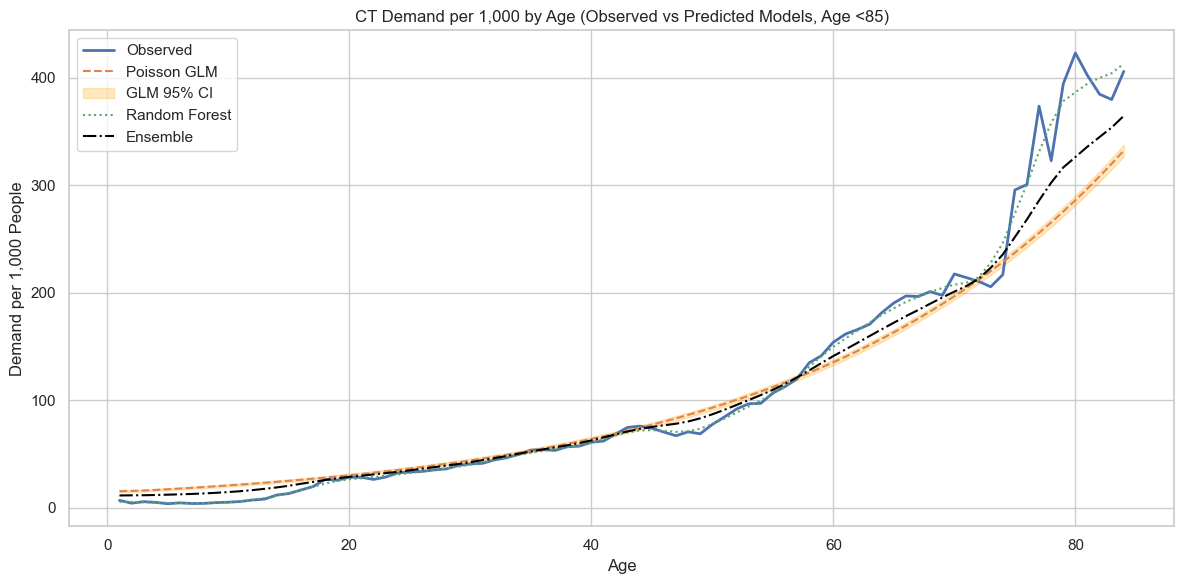

In [19]:
# ---- Step 5.4: Observed vs Predicted Plot for Age <85 ----

plt.figure(figsize=(12, 6))

sns.lineplot(data=model_sub_df, x="age", y="ct_demand_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_sub_df, x="age", y="predicted_glm_smoothed", label="Poisson GLM", linestyle="--")
plt.fill_between(
    model_sub_df["age"],
    model_sub_df["glm_ci_lower_smoothed"],
    model_sub_df["glm_ci_upper_smoothed"],
    color="orange", alpha=0.25, label="GLM 95% CI"
)
sns.lineplot(data=model_sub_df, x="age", y="predicted_rf_smoothed", label="Random Forest", linestyle=":")
sns.lineplot(data=model_sub_df, x="age", y="predicted_ensemble_smoothed", label="Ensemble", linestyle="-.", color="black")

plt.title("CT Demand per 1,000 by Age (Observed vs Predicted Models, Age <85)")
plt.xlabel("Age")
plt.ylabel("Demand per 1,000 People")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# ---- Step 6.1: Prepare Data for Interaction Model ----

# Re-filter only CT rows with valid values
ct_df_int = ct_master_df[ct_master_df["is_ct"] == 1].copy()
ct_df_int = ct_df_int.dropna(subset=["age", "cancer_flag", "patient_source"])
ct_df_int["age"] = ct_df_int["age"].astype(int)
ct_df_int["cancer_flag"] = ct_df_int["cancer_flag"].astype(str)  # ensure string for GLM
ct_df_int["patient_source"] = ct_df_int["patient_source"].astype("category")

# Load population data
population_df = pd.read_csv(POPULATION_PATH)
population_df.rename(columns={"population": "population_2024"}, inplace=True)

# Count CT procedures by age, cancer_flag, patient_source
grouped_df = (
    ct_df_int.groupby(["age", "cancer_flag", "patient_source"])
    .size()
    .reset_index(name="CT_Total")
)

# Merge population
grouped_df = grouped_df.merge(population_df, on="age", how="left")
grouped_df.dropna(subset=["population_2024"], inplace=True)

# Compute demand rate per 1,000 people
grouped_df["ct_demand_per_1k"] = (grouped_df["CT_Total"] / grouped_df["population_2024"]) * 1000


In [21]:
# ---- Step 6.2: Fit GLM with Interaction: age × cancer_flag ----

interaction_formula = "ct_demand_per_1k ~ age * C(cancer_flag) + C(patient_source)"

glm_interaction = smf.glm(
    formula=interaction_formula,
    data=grouped_df,
    family=sm.families.Poisson()
).fit()

# Print GLM summary
print(glm_interaction.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:       ct_demand_per_1k   No. Observations:                 1414
Model:                            GLM   Df Residuals:                     1404
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4377.9
Date:                Mon, 07 Jul 2025   Deviance:                       5690.1
Time:                        14:44:11   Pearson chi2:                 5.75e+03
No. Iterations:                    10   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In [22]:
def compute_ct_demand_per_1k(modality_counts_df, population_dict):
    """
    Compute CT demand per 1,000 people by ONS age bands.

    Parameters:
    - modality_counts_df: DataFrame with CT counts by age_band (must include 'age_band' and 'CT_Total')
    - population_dict: Dictionary mapping age_band to 2024 population estimates

    Returns:
    - DataFrame with age_band, CT_Total, population_2024, ct_demand_per_1k, and normalised demand PDF
    """
    df = modality_counts_df[["age_band", "CT_Total"]].copy()
    df["population_2024"] = df["age_band"].map(population_dict)
    df.dropna(inplace=True)

    # Calculate demand per 1,000
    df["ct_demand_per_1k"] = (df["CT_Total"] / df["population_2024"]) * 1000

    # Calculate normalised demand PDF (proportional to population × rate)
    df["total_demand"] = (df["ct_demand_per_1k"] * df["population_2024"]) / 1000
    total_demand_sum = df["total_demand"].sum()
    df["demand_pdf"] = df["total_demand"] / total_demand_sum

    return df


In [23]:
# Define dictionary of ONS age-band population estimates
age_band_population = {
    "0-4": 283792, "5-9": 322018, "10-14": 331416, "15-19": 324765,
    "20-24": 342425, "25-29": 342688, "30-34": 367510, "35-39": 355513,
    "40-44": 341210, "45-49": 362553, "50-54": 413048, "55-59": 423510,
    "60-64": 376552, "65-69": 337298, "70-74": 357074, "75-79": 266939,
    "80-84": 181501, "85+": 183436
}

# Apply function
ct_demand_df = compute_ct_demand_per_1k(modality_counts_df, age_band_population)
ct_demand_df.head()


,age_band,CT_Total,population_2024,ct_demand_per_1k,total_demand,demand_pdf
0,0-4,2041,283792,7.191887,2041.0,0.003010
1,5-9,1410,322018,4.378637,1410.0,0.002080
2,10-14,2850,331416,8.599464,2850.0,0.004204
3,15-19,7081,324765,21.803458,7081.0,0.010444
4,20-24,10327,342425,30.158429,10327.0,0.015231


In [24]:
def fit_ct_glm_under85(df, age_col="age", demand_col="ct_demand_per_1k", window=5):
    """
    Fit a Poisson GLM to CT demand per 1,000 for ages <85.
    Includes CI, ensemble with RF, and smoothing.

    Parameters:
    - df: DataFrame with 'age' and 'ct_demand_per_1k' columns
    - age_col: Name of the age column
    - demand_col: Name of the demand column
    - window: Smoothing window (e.g., 5-year rolling average)

    Returns:
    - df_result: DataFrame with smoothed predictions and CIs
    - glm_model: Fitted Poisson GLM
    - rf_model: Fitted Random Forest model
    """
    from sklearn.ensemble import RandomForestRegressor
    import statsmodels.formula.api as smf

    # Filter to age < 85
    df_sub = df[df[age_col] < 85].copy()

    # Fit GLM
    glm_model = smf.glm(
        formula=f"{demand_col} ~ {age_col}",
        data=df_sub,
        family=sm.families.Poisson()
    ).fit()
    df_sub["predicted_glm"] = glm_model.predict(df_sub)

    # GLM CI
    ci = glm_model.get_prediction(df_sub).summary_frame(alpha=0.05)
    df_sub["glm_ci_lower"] = ci["mean_ci_lower"]
    df_sub["glm_ci_upper"] = ci["mean_ci_upper"]

    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(df_sub[[age_col]], df_sub[demand_col])
    df_sub["predicted_rf"] = rf_model.predict(df_sub[[age_col]])

    # Ensemble
    df_sub["predicted_ensemble"] = 0.6 * df_sub["predicted_glm"] + 0.4 * df_sub["predicted_rf"]

    # Smoothing
    for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
        df_sub[f"{col}_smoothed"] = df_sub[col].rolling(window=window, center=True, min_periods=1).mean()

    df_sub["glm_ci_lower_smoothed"] = df_sub["glm_ci_lower"].rolling(window=window, center=True, min_periods=1).mean()
    df_sub["glm_ci_upper_smoothed"] = df_sub["glm_ci_upper"].rolling(window=window, center=True, min_periods=1).mean()

    return df_sub, glm_model, rf_model


In [25]:
# Use merged_full from earlier (contains age and ct_demand_per_1k)
model_input_df = merged_full.copy()
model_sub_df, glm_sub, rf_sub = fit_ct_glm_under85(model_input_df)

# Preview results
model_sub_df[["age", "ct_demand_per_1k", "predicted_glm_smoothed", "predicted_rf_smoothed"]].head()


,age,ct_demand_per_1k,predicted_glm_smoothed,predicted_rf_smoothed
0,1,6.93,9.201372,5.54730
1,2,4.31,9.426751,5.42880
2,3,5.72,9.659433,5.18372
3,4,5.03,10.125318,4.79826
4,5,3.81,10.613673,4.61976
